In [1]:
data_dir = "../../data/"
reports_dir = "./reports/"

## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


Le modèle de classification permet de mesurer la similarité de la distribution entre les données (d'entrées) d'entraînement du modèle et celle utilisées réellement (en production).

Il n'est pas nécessaire d'avoir les labels issus de la production pour utiliser cette approche puisque l'on s'intéresse uniquement aux données passées en entrée du modèle (et pas à la prédiction).

On détermine qu'il y a un data-drift à partir de la performance du classifieur. Si le classifieur est performant c'est qu'il arrive à faire la différence entre les données d'entraînement et les données de production, leur distribution est donc différente. Au contraire, le classifieur performe pauvrement quand il a du mal à différencier les données, ce qui veut dire qu'elles ont une distribution similaire.

Installer eurybia

In [ ]:
# pixi add eurybia --pypi

Utiliser eurybia pour monitorer le modèle. Dans un premier temps faire en sorte que les données (df_current) soient de la même distribution que vos données d’entraînement. Vérifier que Eurybia pense que le modèle ne drift pas


In [2]:
import pandas as pd
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split

df = pd.read_csv(data_dir + "houses.csv")
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sd = SmartDrift(df_current=X_train, df_baseline=X_train)
sd.compile()
sd.generate_report(output_file=reports_dir + "report_Xtrain_Xtrain.html", title_story='df_current=X_train & df_baseline=X_train')

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x3595ce390>


Faire de même avec des données de test. Les données de tests ont-elle un drift par rapport au train ?


In [3]:
sd = SmartDrift(df_current=X_test, df_baseline=X_train)
sd.compile()
sd.generate_report(output_file=reports_dir + "report_Xtrain_Xtest.html", title_story='df_current=X_train & df_baseline=X_test')

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x3639b7f10>


Le score AUC obtenu est de 0.5 cela signifie que le classfieur n'arrive pas à différencier les données d'entraînement des données de test. On en conclut qu'il n'y a pas de data-drift entre les données d'entraînement et de test.

Générer des données qui ne ressemblent ni au train ni au test (par exemple avec des données abérentes). Euribya détecte-t-il ces données ?

In [4]:
import numpy as np

rng = np.random.default_rng(42)
X_random = X_train.copy()
X_random['garden'] = np.array([ rng.random() for _ in X_random.index]).astype(int)
X_random['nb_rooms'] = np.array([ rng.random() for _ in X_random.index]).astype(int)
X_random['size'] = [ 30 * rng.random() for _ in X_random.index]

sd = SmartDrift(df_current=X_random, df_baseline=X_train)
sd.compile()
sd.generate_report(output_file=reports_dir + "report_Xrandom_Xtrain.html", title_story='df_current=X_random & df_baseline=X_test')

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x364892f90>


Le `dataframe` `X_random` contient des valeurs abérentes générées aléatoirement. Le score AUC d'Euribya est de 1. Cela signifie que le classifier est performant: il arrive sans problème à différencier `df_current` de `df_baseline` et donc à détecter ces données. Il y a donc un fort data-drift.

## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

In [ ]:
# pixi add alibi-detect tensorflow_probability tensorflow tf_keras "keras==2.*" --pypi

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [5]:
import keras 
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(float) / 255.0
x_test = x_test.astype(float) / 255.0

Dans le sous package alibbi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [6]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [7]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez 1 ou 2 corruptions parmis les suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True
attention le dataset peut être lourd si vous utilisez bcp de corruptions

In [8]:
corruptions = ['gaussian_noise', 'brightness']
X_corr, y_corr = fetch_cifar10c(corruption=corruptions, severity=5, return_X_y=True)

Normaliser les images corrompues

In [9]:
X_corr = X_corr.astype(float) / 255.0

Afficher plusieurs des images corrompues.

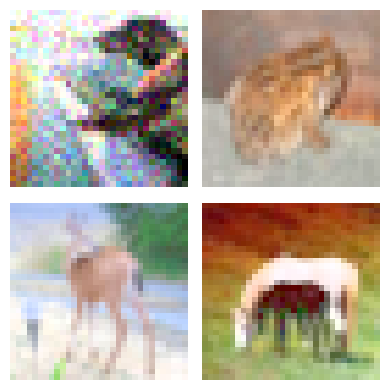

In [10]:
import matplotlib.pyplot as plt
imgs = rng.choice(X_corr, 4)
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
for ax, img in zip(axes.ravel(), imgs):
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [11]:
from alibi_detect.utils.fetching import fetch_tf_model

dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

4293464/4293464 [==============================] - 1s 0us/step


In [12]:
%%bash
data_dir="../../data"
model_filename="resnet32.h5"
if [ -f $model_filename ]; then
    mv $model_filename $data_dir
fi

Calculer la performance du model sur le jeu de train et de test

In [13]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 [==============================] - 5s 15ms/step - loss: 2.0559 - sparse_categorical_accuracy: 0.6042
test loss, test acc: [2.0559349060058594, 0.604200005531311]


Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [14]:
results = model.evaluate(X_corr, y_corr)
print("test loss, test acc:", results)

625/625 [==============================] - 9s 15ms/step - loss: 4.5535 - sparse_categorical_accuracy: 0.3686
test loss, test acc: [4.553515434265137, 0.36855000257492065]


On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [15]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [16]:
X_ref = rng.choice(x_test, 100)

A quoi sert le test statistique kolmogorov smirnoff ?

D'après Wikipédia, le test Kolmogorov-Smirnoff permet de déterminer si deux échantillons suivent la même distribution statistique.

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [17]:
from alibi_detect.cd.tensorflow import preprocess_drift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

In [18]:
from alibi_detect.cd import KSDrift
cd = KSDrift(X_ref, p_val=0.05, preprocess_fn=preprocess_function)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [19]:
labels = ['No!', 'Yes!']
preds = cd.predict(X_ref)
print('Drift on ref? {}'.format(labels[preds['data']['is_drift']]))
preds = cd.predict(X_corr)
print('Drift on corrupted? {}'.format(labels[preds['data']['is_drift']]))

Drift on ref? No!
Drift on corrupted? Yes!
